## 08. cgan for MYDATA.csv

trying to capture temporal trends by feeding in conditions on different days
updating a few structural things about discriminator and training loop

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
import tqdm
from tqdm.auto import tqdm

import os

sns.set_style('white')
sns.set_context('talk')

### Importing data/basic viz

In [3]:
#path = os.path.join('',DATA_FOLDER, DATA_FILE)
# load csv into df
df = pd.read_csv(r'/Users/emilymiura/dowgan/data/mydata.csv', 
                 #delimiter='\t'
                 )
#                 parse_dates=[['Date', 'Time']],
#                 decimal=',')

In [4]:
df

,Temp_stage_1,Temp_stage_2,Temp_stage_3,Temp_stage_4,Temp_stage_5,Temp_stage_6,Temp_stage_7,Temp_stage_8,Temp_stage_9,Temp_stage_10,...,level_11,level_12,h_gas_det_1,h_gas_det_2,h_gas_det_3,h_gas_det_4,h_gas_det_5,h_gas_det_6,Impurities,Pressure Condition
0,140.000000,150.000000,162.000000,165.000000,170.000000,174.000000,178.000000,181.000000,190.000000,201.000000,...,40.000000,45.000000,1.096308,1.872036,2.765414,2.955074,1.986723,2.266643,0.020000,0
1,140.031416,150.031102,162.036945,165.024881,170.024630,174.031102,178.018849,181.025384,190.025133,201.025384,...,40.017718,45.024630,1.107127,1.896500,2.781031,2.947485,1.962102,2.242826,0.020220,0
2,140.062830,150.062202,162.073888,165.049762,170.049259,174.062202,178.037698,181.050767,190.050264,201.050767,...,40.035436,45.049259,1.118487,1.921026,2.796173,2.939322,1.937505,2.218863,0.020442,0
3,140.094242,150.093300,162.110829,165.074640,170.073886,174.093300,178.056545,181.076148,190.075394,201.076148,...,40.053153,45.073886,1.130381,1.945597,2.810831,2.930590,1.912947,2.194769,0.020664,0
4,140.125650,150.124394,162.147766,165.099515,170.098510,174.124394,178.075390,181.101525,190.100520,201.101525,...,40.070868,45.098510,1.142801,1.970199,2.824996,2.921295,1.888445,2.170560,0.020887,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,147.842946,156.307788,166.325537,171.646231,175.550358,180.307788,185.905768,190.114758,197.874357,210.114758,...,41.175447,46.550358,2.422648,1.465737,1.000026,1.453686,2.648207,2.409625,0.024587,1
9996,147.874350,156.337087,166.354813,171.669670,175.569876,180.337087,185.924610,190.139113,197.899480,210.139113,...,41.169526,46.569876,2.404880,1.449342,1.000076,1.470136,2.662945,2.427350,0.024867,1
9997,147.905758,156.366451,166.384228,171.693160,175.589485,180.366451,185.943455,190.163423,197.924606,210.163423,...,41.163703,46.589485,2.386873,1.433080,1.000511,1.486867,2.677497,2.444996,0.025148,1
9998,147.937170,156.395877,166.413779,171.716702,175.609186,180.395877,185.962302,190.187686,197.949736,210.187686,...,41.157980,46.609186,2.368632,1.416962,1.001334,1.503875,2.691856,2.462551,0.025431,1


In [5]:
#Shape of data
print(f'shape of data: {df.shape}')

#Dropping date column and putting column names in a list bc they are so long
# data = df.drop(df.columns[0],axis=1)
# time = np.arange(0,len(data))
# data.insert(0,'Time',time)

#List of all the column names
list_colnames=list(df)
# print(f"shape of data after removing date column and adding time: {data.shape}")
print(f"number of columns: {len(df.columns)}")

shape of data: (10000, 45)
number of columns: 45


In [6]:
# #Counting the number of null values in each column
# na_vals = []
# for x in np.arange(0,len(list_colnames)):
#     na_vals.append(data[list_colnames[x]].isnull().sum())

# na_vals_dict = dict(zip(np.arange(0,len(list_colnames)),na_vals))
# print(na_vals_dict)

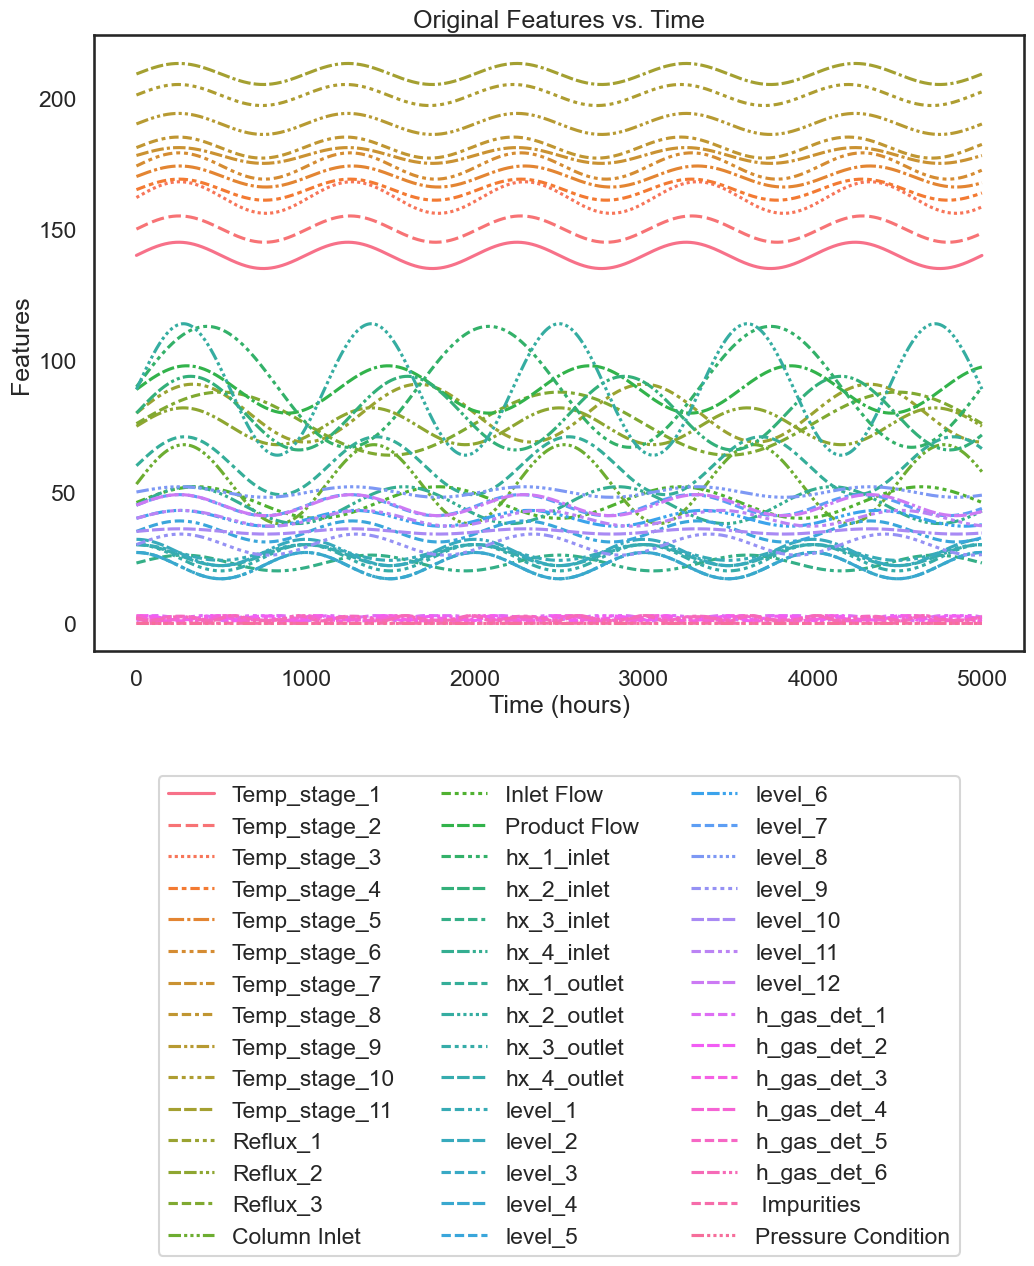

In [7]:
# plotting original data vs time for first 500 points
plt.figure(figsize=(12,8))
sns.lineplot(data=df[0:5000])
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -1), ncol=3)
plt.title('Original Features vs. Time')
plt.xlabel('Time (hours)')
plt.ylabel('Features');

### Splitting data into target and conditions and performing MinMax scaling on target data

In [8]:
# splitting data into target and conditions data
target_data = df.iloc[:,0:44]
print(f"shape of target_tensor (all features): {target_data.shape}")

conditions_data = df['Pressure Condition'].values.reshape(-1,1)
print(f"shape of conditions_tensor (operating conditions): {conditions_data.shape}")

shape of target_tensor (all features): (10000, 44)
shape of conditions_tensor (operating conditions): (10000, 1)


In [9]:
# performing MinMax scaling
scaler = MinMaxScaler(feature_range=(0,1))

# fit & transform scaler data
targets = scaler.fit_transform(target_data)

column_names = list(df.columns.values[0:44])
target_data_scaled = pd.DataFrame(targets, columns=column_names)

In [10]:
target_data_scaled.head()

,Temp_stage_1,Temp_stage_2,Temp_stage_3,Temp_stage_4,Temp_stage_5,Temp_stage_6,Temp_stage_7,Temp_stage_8,Temp_stage_9,Temp_stage_10,...,level_10,level_11,level_12,h_gas_det_1,h_gas_det_2,h_gas_det_3,h_gas_det_4,h_gas_det_5,h_gas_det_6,Impurities
0,0.277778,0.277778,0.300000,0.250000,0.250000,0.277778,0.214286,0.250000,0.250000,0.250000,...,0.166667,0.300000,0.333333,0.048154,0.436018,0.882707,0.977537,0.493362,0.633321,0.160207
1,0.279523,0.279506,0.301847,0.251555,0.251539,0.279506,0.215632,0.251586,0.251571,0.251586,...,0.167693,0.301772,0.335386,0.053563,0.448250,0.890516,0.973743,0.481051,0.621413,0.162168
2,0.281268,0.281233,0.303694,0.253110,0.253079,0.281233,0.216978,0.253173,0.253142,0.253173,...,0.168719,0.303544,0.337438,0.059244,0.460513,0.898087,0.969661,0.468752,0.609431,0.164137
3,0.283013,0.282961,0.305541,0.254665,0.254618,0.282961,0.218325,0.254759,0.254712,0.254759,...,0.169745,0.305315,0.339491,0.065191,0.472799,0.905416,0.965295,0.456473,0.597384,0.166115
4,0.284758,0.284689,0.307388,0.256220,0.256157,0.284689,0.219671,0.256345,0.256283,0.256345,...,0.170771,0.307087,0.341543,0.071401,0.485099,0.912498,0.960648,0.444223,0.585280,0.168101


### Putting data into tensors 

In [11]:
# converting target and conditions into tensors
target_tensor = torch.tensor(target_data_scaled.values, dtype=torch.float32)
print(f"shape of target_tensor (all features): {target_tensor.shape}")

conditions_tensor = torch.tensor(conditions_data, dtype=torch.float32)
print(f"shape of conditions_tensor (operating conditions): {conditions_tensor.shape}")

# print(f'first timepoint (row): {target_tensor[0]}')
# print(f'first feature (col): {target_tensor[:,0]}')

shape of target_tensor (all features): torch.Size([10000, 44])
shape of conditions_tensor (operating conditions): torch.Size([10000, 1])


### Batching data

We are aiming for a list of tensors (target_tensor_list and condition_tensor_list) that have shapes:
* `target_tensor_list = [59, 168, 45]`
* `conditions_tensor_list = [59, 168, 1]`
* where the shape is [`N_SAMPLES`, `N_DATAPOINTS`, `N_FEATURES`]

we are also REMOVING any hours with NaN values present

In [14]:
10000 // 168

59

In [15]:
# Included step where is there is a nan value to not include it in the final tensor list
# Not sure if this is how we want to do this rn but an idea.

# Data is taken per hour - splitting up batches into "days" of data
# N_SAMPLES = 10177 // 168 = 59 WEEKS of data where each CHUNK is 1 week

N_DATAPOINTS = 168
N_SAMPLES = len(target_tensor) // N_DATAPOINTS

target_tensor_list = []
conditions_tensor_list = []
invalid_batch_indexes = []

#Iterating through all of the data and dividing it up
for i in np.arange(0, N_SAMPLES, 1):
    
    #Taking a batch of the target data
    a = torch.split(target_tensor, N_DATAPOINTS, dim=0)[i]
    #Checking for any NaNs in that tensor
    # if its true, not saving it and the condition tensor to the list
    if torch.isnan(a).any() == True:
        invalid_batch_indexes.append(i)
        continue
    else:
        target_tensor_list.append(a)

    #Taking the corresponding batch of conditions
    b = torch.split(conditions_tensor, N_DATAPOINTS, dim=0)[i]
    conditions_tensor_list.append(b)

print(f'length of data: {df.shape[0]}')
print(f'We have {len(target_tensor_list)} samples with {N_DATAPOINTS} datapoints in each.')
print(f'There are {len(invalid_batch_indexes)} invalid batches.')

length of data: 10000
We have 59 samples with 168 datapoints in each.
There are 0 invalid batches.


In [16]:
#Confirming # of tensors and condition lists
#Confirming that the last batch has 101 points (not truncating)
print(f'length of target: {len(target_tensor_list)}')
print(f'length of conditions: {len(conditions_tensor_list)}')
print(f'shape of last target tensor: {target_tensor_list[len(target_tensor_list)-1].shape}')
print(f'shape of last condition tensor: {conditions_tensor_list[len(target_tensor_list)-1].shape}')


length of target: 59
length of conditions: 59
shape of last target tensor: torch.Size([168, 44])
shape of last condition tensor: torch.Size([168, 1])


In [17]:
# making a custom dataset class
class ImpuritiesDataset(Dataset):
    def __init__(self, target, conditions):
        self.target = target
        self.conditions = conditions
    def __len__(self):
        return len(self.conditions)
    def __getitem__(self, idx):
        condition = self.conditions[idx]
        target = self.target[idx]
        return target, condition

In [18]:
#Inputting data into Dataset class
train_data = ImpuritiesDataset(target=target_tensor_list,
                               conditions=conditions_tensor_list)
target, condition = next(iter(train_data))[0], next(iter(train_data))[1]
print(target.shape)
print(condition.shape)

torch.Size([168, 44])
torch.Size([168, 1])


### Inputting Data into dataloader

In [20]:
from torch.utils.data import DataLoader

BATCH_SIZE = 10

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

print(f"dataloader: {train_dataloader}")
print(f"length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE} (batch_size) examples")
print(f"number of total examples: {len(train_data)} \neach example containing... \n\tTARGET shape (number of timepoints): {train_data[0][0].shape} \n\tCONDITION shape (class 1 or 2): {train_data[0][1].shape}")

dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7fc080ebbc40>
length of train_dataloader: 6 batches of 10 (batch_size) examples
number of total examples: 59 
each example containing... 
	TARGET shape (number of timepoints): torch.Size([168, 44]) 
	CONDITION shape (class 1 or 2): torch.Size([168, 1])


In [21]:
# # for loop to check the size of batch in the dataloader
# # BATCH NUMBER 18 is SMALLER -> it is left out of the training loop
# for i, (target, condition) in enumerate(train_dataloader):
#     print(i, len(condition))

### Running 1 batch of targets and conditions through test layers

In [22]:
train_target_batch, train_condition_batch = next(iter(train_dataloader))
print(f"training target batch size: {train_target_batch.shape}")
print(f"training condition batch: {train_condition_batch.shape}")

training target batch size: torch.Size([10, 168, 44])
training condition batch: torch.Size([10, 168, 1])


In [23]:
# concatening batched data together for forward pass
train_input_batch = torch.cat([train_target_batch, train_condition_batch], axis=2)
print(train_input_batch.shape)

# transposing concatenated data for input into conv1d layer [batchsize, columns, datapoints]
train_input_batch_transposed = torch.transpose(train_input_batch, 1, 2)
print(train_input_batch_transposed.shape)

torch.Size([10, 168, 45])
torch.Size([10, 45, 168])


In [24]:
4032/8

504.0

In [27]:
704/8

88.0

In [28]:
# trying out Conv1d + LeakyReLU + Max Pooling + Flatten - for discriminator
# based on this cgan structure:
# https://towardsdatascience.com/cgan-conditional-generative-adversarial-network-how-to-gain-control-over-gan-outputs-b30620bd0cc8

input_shape = 45
hidden_size = 8
output_shape = 1

conv1d_0 = nn.Conv1d(in_channels=input_shape,
                        out_channels=hidden_size,
                        kernel_size=3,
                        stride=1,
                        padding=1)
conv1d_out = conv1d_0(train_input_batch_transposed)
print("conv1d_out (0): ", conv1d_out.shape)

maxpool_0 = nn.MaxPool1d(kernel_size=3, 
                            stride=2, 
                            padding=1)
maxpool_0_out = maxpool_0(conv1d_out)
print("max pool 0 out:", maxpool_0_out.shape)

# leaky_relu_0 = nn.LeakyReLU(negative_slope=0.2)
# leaky_relu_out = leaky_relu_0(maxpool_0_out)
# print("leaky_relu_out (0): ", leaky_relu_out.shape)

conv1d_1 = nn.Conv1d(in_channels=hidden_size,
                        out_channels=hidden_size*2,
                        kernel_size=3,
                        stride=1,
                        padding=1)
conv1d_1_out = conv1d_1(maxpool_0_out)
print("conv1d_1_out: ", conv1d_1_out.shape)

maxpool_1 = nn.MaxPool1d(kernel_size=3, 
                            stride=2, 
                            padding=1)
maxpool_1_out = maxpool_1(conv1d_1_out)
print("maxpool_1_out: ", maxpool_1_out.shape)

# leaky_relu_1 = nn.LeakyReLU(negative_slope=0.2)
# leaky_relu_1_out = leaky_relu_1(maxpool_1_out)
# print("leaky_relu_out (1): ", leaky_relu_1_out.shape)

conv1d_2 = nn.Conv1d(in_channels=hidden_size*2,
                        out_channels=hidden_size*4,
                        kernel_size=3,
                        stride=1,
                        padding=1)
conv1d_2_out = conv1d_2(maxpool_1_out)
print("conv1d_2_out: ", conv1d_2_out.shape)

maxpool_2 = nn.MaxPool1d(kernel_size=3, 
                            stride=2, 
                            padding=1)
maxpool_2_out = maxpool_2(conv1d_2_out)
print("maxpool_2_out: ", maxpool_2_out.shape)

conv1d_3 = nn.Conv1d(in_channels=hidden_size*4,
                        out_channels=hidden_size*8,
                        kernel_size=3,
                        stride=1,
                        padding=1)
conv1d_3_out = conv1d_3(maxpool_2_out)
print("conv1d_2_out: ", conv1d_3_out.shape)

maxpool_3 = nn.MaxPool1d(kernel_size=3, 
                            stride=2, 
                            padding=1)
maxpool_3_out = maxpool_3(conv1d_3_out)
print("maxpool_2_out: ", maxpool_3_out.shape)

# passing through flatten layer
flatten = nn.Flatten()
flatten_out = flatten(maxpool_3_out)
print("flatten_out: ", flatten_out.shape)

# dropout layer
dropout = nn.Dropout(p=0.2)
dropout_out = dropout(flatten_out)
print("dropout_out: ", dropout_out.shape)

# transposed_0 = torch.transpose(dropout_out, 1, 2)
# print("transposed: ", transposed_0.shape)

# adding linear layer to get size to 1
linear = nn.Linear(in_features=hidden_size*88,
                   out_features=output_shape)
linear_out = linear(dropout_out)
print("linear_out: ", linear_out.shape)

# finally activation function sigmoid
sigmoid = nn.Sigmoid()
sigmoid_out = sigmoid(linear_out)
print("sigmoid_out: ", sigmoid_out.shape)

conv1d_out (0):  torch.Size([10, 8, 168])
max pool 0 out: torch.Size([10, 8, 84])
conv1d_1_out:  torch.Size([10, 16, 84])
maxpool_1_out:  torch.Size([10, 16, 42])
conv1d_2_out:  torch.Size([10, 32, 42])
maxpool_2_out:  torch.Size([10, 32, 21])
conv1d_2_out:  torch.Size([10, 64, 21])
maxpool_2_out:  torch.Size([10, 64, 11])
flatten_out:  torch.Size([10, 704])
dropout_out:  torch.Size([10, 704])
linear_out:  torch.Size([10, 1])
sigmoid_out:  torch.Size([10, 1])


In [29]:
2673/168

15.910714285714286

In [30]:
# trying out convtranspose1d + relu + tanh activation - for generator
# based on this cgan structure:
# https://towardsdatascience.com/cgan-conditional-generative-adversarial-network-how-to-gain-control-over-gan-outputs-b30620bd0cc8

conv1d_transpose_0 = nn.Conv1d(in_channels=45,
                        out_channels=8,
                        kernel_size=3,
                        stride=2,
                        padding=1)
conv1d_transpose_out_0 = conv1d_transpose_0(train_input_batch_transposed)
print("conv1d_transpose_out (0): ", conv1d_transpose_out_0.shape)

relu_0 = nn.ReLU()
relu_out_0 = relu_0(conv1d_transpose_out_0)
print("relu_out (0): ", relu_out_0.shape)

conv1d_transpose_1 = nn.Conv1d(in_channels=8,
                        out_channels=8*2,
                        kernel_size=3,
                        stride=2,
                        padding=1)
conv1d_transpose_out_1 = conv1d_transpose_1(relu_out_0)
print("conv1d_transpose_out (1): ", conv1d_transpose_out_1.shape)

relu_1 = nn.ReLU()
relu_out_1 = relu_1(conv1d_transpose_out_1)
print("relu_out (1): ", relu_out_1.shape)


conv1d_transpose_2 = nn.Conv1d(in_channels=8*2,
                        out_channels=8*4,
                        kernel_size=3,
                        stride=2,
                        padding=1)
conv1d_transpose_out_2 = conv1d_transpose_2(relu_out_1)
print("conv1d_transpose_out (2): ", conv1d_transpose_out_2.shape)

relu_2 = nn.ReLU()
relu_out_2 = relu_2(conv1d_transpose_out_2)
print("relu_out (2): ", relu_out_2.shape)

conv1d_transpose_3 = nn.Conv1d(in_channels=8*4,
                        out_channels=8*2,
                        kernel_size=3,
                        stride=2,
                        padding=1)
conv1d_transpose_out_3 = conv1d_transpose_3(relu_out_2)
print("conv1d_transpose_out (3): ", conv1d_transpose_out_3.shape)

relu_3 = nn.ReLU()
relu_out_3 = relu_3(conv1d_transpose_out_3)
print("relu_out (3): ", relu_out_3.shape)

conv1d_transpose_4 = nn.Conv1d(in_channels=8*2,
                        out_channels=8,
                        kernel_size=3,
                        stride=2,
                        padding=1)
conv1d_transpose_out_4 = conv1d_transpose_4(relu_out_3)
print("conv1d_transpose_out (4): ", conv1d_transpose_out_4.shape)

relu_4 = nn.ReLU()
relu_out_4 = relu_4(conv1d_transpose_out_4)
print("relu_out (4): ", relu_out_4.shape)

#batch norm output
batchnorm = nn.BatchNorm1d(num_features=8)
batchnorm_out = batchnorm(relu_out_4)
print("batchnorm_out: ", batchnorm_out.shape)

# conv1d output layer
conv1d_2 = nn.Conv1d(in_channels=8,
                     out_channels=44,
                     kernel_size=3,
                     stride=2,
                     padding=1)
conv1d_out_2 = conv1d_2(batchnorm_out)
print("conv1d_out_2: ", conv1d_out_2.shape)

linear = nn.Linear(in_features=3,
                   out_features=168)
linear_out = linear(conv1d_out_2)
print("linear out: ", linear_out.shape)

# activation function tanh?
transposed = torch.transpose(linear_out, 1, 2)
print("transposed: ", transposed.shape)
tanh = nn.Tanh()
tanh_out = tanh(transposed)
print("tanh_out: ", tanh_out.shape)

# linear_1 = nn.Linear(in_features=8,
#                      out_features=45)
# linear_out_1 = linear_1(transposed)
# print("linear_out_1: ", linear_out_1.shape)

conv1d_transpose_out (0):  torch.Size([10, 8, 84])
relu_out (0):  torch.Size([10, 8, 84])
conv1d_transpose_out (1):  torch.Size([10, 16, 42])
relu_out (1):  torch.Size([10, 16, 42])
conv1d_transpose_out (2):  torch.Size([10, 32, 21])
relu_out (2):  torch.Size([10, 32, 21])
conv1d_transpose_out (3):  torch.Size([10, 16, 11])
relu_out (3):  torch.Size([10, 16, 11])
conv1d_transpose_out (4):  torch.Size([10, 8, 6])
relu_out (4):  torch.Size([10, 8, 6])
batchnorm_out:  torch.Size([10, 8, 6])
conv1d_out_2:  torch.Size([10, 44, 3])
linear out:  torch.Size([10, 44, 168])
transposed:  torch.Size([10, 168, 44])
tanh_out:  torch.Size([10, 168, 44])


In [31]:
168/6

28.0

### coding discriminator and generator

In [32]:
# defining a disciminator model

from torch import nn

class Discriminator(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        # input shape is number of columns
        # output shape is 2 (for probability of 0 or 1)

        # pass concatenated target+conditions through nn.Sequential
        self.main = nn.Sequential(
            # input is INPUT SHAPE // number of columns/channels
            nn.Conv1d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False),
            # nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool1d(kernel_size=3,
                         stride=2,
                         padding=1),
            nn.Conv1d(in_channels=hidden_units,
                      out_channels=hidden_units*2,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False),
            # nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool1d(kernel_size=3,
                         stride=2,
                         padding=1),
            nn.Conv1d(in_channels=hidden_units*2,
                      out_channels=hidden_units*4,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.MaxPool1d(kernel_size=3,
                         stride=2,
                         padding=1),
            nn.Conv1d(in_channels=hidden_units*4,
                      out_channels=hidden_units*8,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.MaxPool1d(kernel_size=3,
                         stride=2,
                         padding=1),
            nn.Flatten(),
            nn.Dropout(p=0.2),
        )

        self.linearize = nn.Sequential(
            nn.Linear(in_features=hidden_units*88,
                      out_features=output_shape),
            nn.Sigmoid() # output of probability
        )

    def forward(self, target, conditions):
        """takes target and conditions as batches"""
        # concatenating and transposing
        data = torch.cat([target, conditions], axis=2)
        data_in = torch.transpose(data, 1, 2)

        # forward pass through nn.Main
        out = self.main(data_in)
        # forward pass through nn.linear + nn.sigmoid
        out = self.linearize(out)
    
        return out

In [33]:
# defining a generator model

from torch import nn

class Generator(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        # input shape is number of columns
        # output shape is 2 (for probability of 0 or 1)

        # pass concatenated target+conditions through nn.Sequential
        self.main = nn.Sequential(
            # input is INPUT SHAPE // number of columns/channels
            nn.ConvTranspose1d(in_channels=input_shape,
                               out_channels=hidden_units,
                               kernel_size=3,
                               stride=1,
                               padding=1),
            nn.BatchNorm1d(num_features=hidden_units),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=hidden_units,
                               out_channels=hidden_units*2,
                               kernel_size=3,
                               stride=1,
                               padding=1),
            nn.BatchNorm1d(num_features=hidden_units*2),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=hidden_units*2,
                    out_channels=hidden_units*4,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.BatchNorm1d(num_features=hidden_units*4),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=hidden_units*4,
                    out_channels=hidden_units*2,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.BatchNorm1d(num_features=hidden_units*2),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=hidden_units*2,
                               out_channels=hidden_units,
                               kernel_size=3,
                               stride=1,
                               padding=1),
            nn.BatchNorm1d(num_features=hidden_units),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_units),
            nn.Conv1d(in_channels=hidden_units,
                      out_channels=output_shape,
                      kernel_size=3,
                      stride=1,
                      padding=1)
    	)

        self.tanh = nn.Tanh()

    def forward(self, noise, conditions):
        """takes target and conditions as batches"""
        # concatenating and transposing
        data = torch.cat([noise, conditions], axis=2)
        data_in = torch.transpose(data, 1, 2)

        # forward pass through nn.Main
        out = self.main(data_in)

        # tranposing the data for activation function
        data_in = torch.transpose(out, 1, 2)

        # forward pass through nn.Activation
        out = self.tanh(data_in)
    
        return out

In [34]:
# input shape is number of channels (X features), target+conditions columns
# output shape is number of probabilities (0, 1 for true or false)
netD = Discriminator(input_shape=45, hidden_units=8, output_shape=1)
netD

Discriminator(
  (main): Sequential(
    (0): Conv1d(45, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (6): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Dropout(p=0.2, inplace=False)
  )
  (linearize): Sequential(
    (0): Linear(in_features=704, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [35]:
netG = Generator(input_shape=45, hidden_units=8, output_shape=44)
netG

Generator(
  (main): Sequential(
    (0): ConvTranspose1d(45, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (10): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): BatchNorm1d(8, eps=1e-05, momentum=0.1, af

In [36]:
loss_D_list = []
loss_G_list = []

epochs = 1000

netD.train()
netG.train()

# optimizer for discriminator and generator
optimizerD = torch.optim.Adam(netD.parameters(),lr=0.0002,betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(),lr=0.0002,betas=(0.5, 0.999))

G_loss_fn = nn.MSELoss()
D_loss_fn = nn.BCELoss()

# Iterating through epochs
for epoch in tqdm(range(epochs)):

	# Iterating through batches (i: iterable int, target: target, condition: condition)
    for i, (target, condition) in enumerate(train_dataloader):

        real_condition = torch.ones([BATCH_SIZE, 1], dtype=torch.float)
        fake_condition = torch.zeros([BATCH_SIZE, 1], dtype=torch.float)

        # for iterating through only FULL BATCHES
        if len(condition) == BATCH_SIZE:
            # initializng fixed noise to generator
            '''
                Update G network: maximize log(D(G(z)))
            '''
            optimizerG.zero_grad()

            # sample noise
            fixed_noise = torch.randn((BATCH_SIZE, N_DATAPOINTS, len(column_names)))
            new_condition = torch.randint(0, 1, [BATCH_SIZE, N_DATAPOINTS, 1], dtype=int)
            
            # generate images
            G_result = netG(fixed_noise, new_condition)

            # measure discriminator
            D_fake_result = netD(G_result, new_condition)
            G_train_loss = G_loss_fn(D_fake_result, real_condition)

            # Back propagation
            G_train_loss.backward()
            optimizerG.step()


            '''
                Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            '''
            optimizerD.zero_grad()

            # Inputting real results into discriminator
            D_real_result = netD(target, condition)
            D_real_loss = D_loss_fn(D_real_result, real_condition)

            # Loss for fake images
            G_result = netG(fixed_noise, new_condition)
            D_fake_result = netD(G_result, new_condition)
            D_fake_loss = D_loss_fn(D_fake_result, fake_condition)

            # Back propagation
            D_train_loss = (D_real_loss + D_fake_loss) / 2
            D_train_loss.backward()
            optimizerD.step()
            
        else:
            pass

    # per epoch, append loss info:
    loss_G_list.append(G_train_loss)
    loss_D_list.append(D_train_loss)

    # print progress per 10 epochs
    if (epoch) % 10 == 0:
                print(f"Epoch: {epoch}/{epochs} | D_loss: {D_train_loss:.4f} | G_loss: {G_train_loss:.4f}")
    else:
          pass

  0%|          | 1/1000 [00:00<07:46,  2.14it/s]

Epoch: 0/1000 | D_loss: 0.7003 | G_loss: 0.2634


  1%|          | 11/1000 [00:04<06:47,  2.43it/s]

Epoch: 10/1000 | D_loss: 0.0880 | G_loss: 0.7140


  2%|▏         | 21/1000 [00:09<06:58,  2.34it/s]

Epoch: 20/1000 | D_loss: 0.0096 | G_loss: 0.9634


  3%|▎         | 31/1000 [00:13<07:49,  2.07it/s]

Epoch: 30/1000 | D_loss: 0.0034 | G_loss: 0.9867


  4%|▍         | 41/1000 [00:18<07:36,  2.10it/s]

Epoch: 40/1000 | D_loss: 0.0015 | G_loss: 0.9940


  5%|▌         | 51/1000 [00:23<07:25,  2.13it/s]

Epoch: 50/1000 | D_loss: 0.0012 | G_loss: 0.9952


  6%|▌         | 61/1000 [00:28<08:00,  1.95it/s]

Epoch: 60/1000 | D_loss: 0.0029 | G_loss: 0.9913


  7%|▋         | 71/1000 [00:33<07:14,  2.14it/s]

Epoch: 70/1000 | D_loss: 0.0008 | G_loss: 0.9974


  8%|▊         | 81/1000 [00:37<07:06,  2.15it/s]

Epoch: 80/1000 | D_loss: 0.0018 | G_loss: 0.9932


  9%|▉         | 91/1000 [00:42<06:23,  2.37it/s]

Epoch: 90/1000 | D_loss: 0.0011 | G_loss: 0.9974


 10%|█         | 101/1000 [00:46<06:54,  2.17it/s]

Epoch: 100/1000 | D_loss: 0.0025 | G_loss: 0.9931


 11%|█         | 111/1000 [00:51<07:07,  2.08it/s]

Epoch: 110/1000 | D_loss: 0.0022 | G_loss: 0.9935


 12%|█▏        | 121/1000 [00:58<08:01,  1.83it/s]

Epoch: 120/1000 | D_loss: 0.0069 | G_loss: 0.9844


 13%|█▎        | 131/1000 [01:03<07:07,  2.03it/s]

Epoch: 130/1000 | D_loss: 0.0086 | G_loss: 0.9843


 14%|█▍        | 141/1000 [01:07<06:05,  2.35it/s]

Epoch: 140/1000 | D_loss: 0.0016 | G_loss: 0.9944


 15%|█▌        | 151/1000 [01:12<07:36,  1.86it/s]

Epoch: 150/1000 | D_loss: 0.0214 | G_loss: 0.9548


 16%|█▌        | 161/1000 [01:17<06:30,  2.15it/s]

Epoch: 160/1000 | D_loss: 0.0596 | G_loss: 0.9117


 17%|█▋        | 171/1000 [01:21<06:03,  2.28it/s]

Epoch: 170/1000 | D_loss: 0.0007 | G_loss: 1.0000


 18%|█▊        | 181/1000 [01:26<07:03,  1.93it/s]

Epoch: 180/1000 | D_loss: 0.0007 | G_loss: 0.9998


 19%|█▉        | 191/1000 [01:30<05:10,  2.61it/s]

Epoch: 190/1000 | D_loss: 0.0311 | G_loss: 0.9692


 20%|██        | 201/1000 [01:34<04:49,  2.76it/s]

Epoch: 200/1000 | D_loss: 0.1711 | G_loss: 0.8906


 21%|██        | 211/1000 [01:37<04:14,  3.10it/s]

Epoch: 210/1000 | D_loss: 0.2025 | G_loss: 0.7783


 22%|██▏       | 221/1000 [01:41<04:14,  3.06it/s]

Epoch: 220/1000 | D_loss: 0.1129 | G_loss: 0.9008


 23%|██▎       | 231/1000 [01:45<04:22,  2.93it/s]

Epoch: 230/1000 | D_loss: 0.0020 | G_loss: 0.9962


 24%|██▍       | 241/1000 [01:48<04:48,  2.63it/s]

Epoch: 240/1000 | D_loss: 0.0577 | G_loss: 0.9186


 25%|██▌       | 251/1000 [01:52<04:08,  3.02it/s]

Epoch: 250/1000 | D_loss: 0.1094 | G_loss: 0.9004


 26%|██▌       | 261/1000 [01:55<04:11,  2.94it/s]

Epoch: 260/1000 | D_loss: 0.3294 | G_loss: 0.7478


 27%|██▋       | 271/1000 [01:58<04:27,  2.73it/s]

Epoch: 270/1000 | D_loss: 0.0106 | G_loss: 0.9916


 28%|██▊       | 281/1000 [02:02<04:50,  2.48it/s]

Epoch: 280/1000 | D_loss: 0.1773 | G_loss: 0.7006


 29%|██▉       | 291/1000 [02:07<05:20,  2.21it/s]

Epoch: 290/1000 | D_loss: 0.0861 | G_loss: 0.8888


 30%|███       | 301/1000 [02:11<04:49,  2.41it/s]

Epoch: 300/1000 | D_loss: 0.2798 | G_loss: 0.7353


 31%|███       | 311/1000 [02:15<05:21,  2.14it/s]

Epoch: 310/1000 | D_loss: 0.1828 | G_loss: 0.7179


 32%|███▏      | 321/1000 [02:20<04:53,  2.32it/s]

Epoch: 320/1000 | D_loss: 0.1533 | G_loss: 0.7110


 33%|███▎      | 331/1000 [02:24<05:00,  2.22it/s]

Epoch: 330/1000 | D_loss: 0.1854 | G_loss: 0.6733


 34%|███▍      | 341/1000 [02:28<04:20,  2.53it/s]

Epoch: 340/1000 | D_loss: 0.1688 | G_loss: 0.7606


 35%|███▌      | 351/1000 [02:32<04:16,  2.53it/s]

Epoch: 350/1000 | D_loss: 0.1578 | G_loss: 0.7206


 36%|███▌      | 361/1000 [02:37<05:03,  2.11it/s]

Epoch: 360/1000 | D_loss: 0.1900 | G_loss: 0.6619


 37%|███▋      | 371/1000 [02:41<04:23,  2.39it/s]

Epoch: 370/1000 | D_loss: 0.0858 | G_loss: 0.8366


 38%|███▊      | 381/1000 [02:46<04:39,  2.21it/s]

Epoch: 380/1000 | D_loss: 0.1478 | G_loss: 0.6476


 39%|███▉      | 391/1000 [02:51<05:11,  1.95it/s]

Epoch: 390/1000 | D_loss: 0.1664 | G_loss: 0.6271


 40%|████      | 401/1000 [02:55<04:22,  2.28it/s]

Epoch: 400/1000 | D_loss: 0.1942 | G_loss: 0.5427


 41%|████      | 411/1000 [03:00<04:42,  2.08it/s]

Epoch: 410/1000 | D_loss: 0.2489 | G_loss: 0.4426


 42%|████▏     | 421/1000 [03:04<04:09,  2.32it/s]

Epoch: 420/1000 | D_loss: 0.2286 | G_loss: 0.4713


 43%|████▎     | 431/1000 [03:09<04:09,  2.28it/s]

Epoch: 430/1000 | D_loss: 0.2288 | G_loss: 0.4354


 44%|████▍     | 441/1000 [03:13<04:14,  2.19it/s]

Epoch: 440/1000 | D_loss: 0.2425 | G_loss: 0.4444


 45%|████▌     | 451/1000 [03:18<04:16,  2.14it/s]

Epoch: 450/1000 | D_loss: 0.2541 | G_loss: 0.4406


 46%|████▌     | 461/1000 [03:23<04:11,  2.15it/s]

Epoch: 460/1000 | D_loss: 0.2503 | G_loss: 0.3952


 47%|████▋     | 471/1000 [03:27<03:45,  2.34it/s]

Epoch: 470/1000 | D_loss: 0.2315 | G_loss: 0.4573


 48%|████▊     | 481/1000 [03:31<04:11,  2.07it/s]

Epoch: 480/1000 | D_loss: 0.2574 | G_loss: 0.3709


 49%|████▉     | 491/1000 [03:36<03:55,  2.16it/s]

Epoch: 490/1000 | D_loss: 0.2670 | G_loss: 0.3575


 50%|█████     | 501/1000 [03:40<03:40,  2.26it/s]

Epoch: 500/1000 | D_loss: 0.2725 | G_loss: 0.3356


 51%|█████     | 511/1000 [03:45<03:38,  2.23it/s]

Epoch: 510/1000 | D_loss: 0.2678 | G_loss: 0.3589


 52%|█████▏    | 521/1000 [03:49<03:27,  2.31it/s]

Epoch: 520/1000 | D_loss: 0.2578 | G_loss: 0.3722


 53%|█████▎    | 531/1000 [03:53<03:09,  2.47it/s]

Epoch: 530/1000 | D_loss: 0.2593 | G_loss: 0.3423


 54%|█████▍    | 541/1000 [03:57<03:13,  2.37it/s]

Epoch: 540/1000 | D_loss: 0.2622 | G_loss: 0.3691


 55%|█████▌    | 551/1000 [04:02<03:22,  2.22it/s]

Epoch: 550/1000 | D_loss: 0.2355 | G_loss: 0.4089


 56%|█████▌    | 561/1000 [04:06<03:23,  2.15it/s]

Epoch: 560/1000 | D_loss: 0.2305 | G_loss: 0.3932


 57%|█████▋    | 571/1000 [04:11<03:08,  2.28it/s]

Epoch: 570/1000 | D_loss: 0.2442 | G_loss: 0.3661


 58%|█████▊    | 581/1000 [04:15<02:49,  2.47it/s]

Epoch: 580/1000 | D_loss: 0.2323 | G_loss: 0.4103


 59%|█████▉    | 591/1000 [04:19<02:44,  2.48it/s]

Epoch: 590/1000 | D_loss: 0.2500 | G_loss: 0.3983


 60%|██████    | 601/1000 [04:23<02:55,  2.28it/s]

Epoch: 600/1000 | D_loss: 0.2526 | G_loss: 0.3731


 61%|██████    | 611/1000 [04:28<03:08,  2.07it/s]

Epoch: 610/1000 | D_loss: 0.2580 | G_loss: 0.3544


 62%|██████▏   | 621/1000 [04:33<02:55,  2.16it/s]

Epoch: 620/1000 | D_loss: 0.2395 | G_loss: 0.4040


 63%|██████▎   | 631/1000 [04:39<03:02,  2.02it/s]

Epoch: 630/1000 | D_loss: 0.2382 | G_loss: 0.3688


 64%|██████▍   | 641/1000 [04:43<03:00,  1.99it/s]

Epoch: 640/1000 | D_loss: 0.2375 | G_loss: 0.3873


 65%|██████▌   | 651/1000 [04:48<02:44,  2.12it/s]

Epoch: 650/1000 | D_loss: 0.2352 | G_loss: 0.3884


 66%|██████▌   | 661/1000 [04:53<02:24,  2.34it/s]

Epoch: 660/1000 | D_loss: 0.2418 | G_loss: 0.3819


 67%|██████▋   | 671/1000 [04:57<02:16,  2.41it/s]

Epoch: 670/1000 | D_loss: 0.2499 | G_loss: 0.3820


 68%|██████▊   | 681/1000 [05:01<02:18,  2.30it/s]

Epoch: 680/1000 | D_loss: 0.2251 | G_loss: 0.4100


 69%|██████▉   | 691/1000 [05:06<02:30,  2.05it/s]

Epoch: 690/1000 | D_loss: 0.2169 | G_loss: 0.4355


 70%|███████   | 701/1000 [05:11<02:13,  2.23it/s]

Epoch: 700/1000 | D_loss: 0.2381 | G_loss: 0.4146


 71%|███████   | 711/1000 [05:16<03:00,  1.60it/s]

Epoch: 710/1000 | D_loss: 0.2525 | G_loss: 0.3968


 72%|███████▏  | 721/1000 [05:21<02:13,  2.09it/s]

Epoch: 720/1000 | D_loss: 0.2517 | G_loss: 0.4180


 73%|███████▎  | 731/1000 [05:25<01:52,  2.39it/s]

Epoch: 730/1000 | D_loss: 0.2617 | G_loss: 0.4000


 74%|███████▍  | 741/1000 [05:29<01:42,  2.54it/s]

Epoch: 740/1000 | D_loss: 0.2707 | G_loss: 0.3790


 75%|███████▌  | 751/1000 [05:33<01:40,  2.48it/s]

Epoch: 750/1000 | D_loss: 0.2360 | G_loss: 0.3821


 76%|███████▌  | 761/1000 [05:37<01:30,  2.64it/s]

Epoch: 760/1000 | D_loss: 0.2247 | G_loss: 0.4024


 77%|███████▋  | 771/1000 [05:40<01:26,  2.65it/s]

Epoch: 770/1000 | D_loss: 0.2086 | G_loss: 0.4232


 78%|███████▊  | 781/1000 [05:44<01:20,  2.71it/s]

Epoch: 780/1000 | D_loss: 0.2298 | G_loss: 0.4054


 79%|███████▉  | 791/1000 [05:48<01:21,  2.58it/s]

Epoch: 790/1000 | D_loss: 0.2290 | G_loss: 0.4098


 80%|████████  | 801/1000 [05:52<01:22,  2.41it/s]

Epoch: 800/1000 | D_loss: 0.2269 | G_loss: 0.4234


 81%|████████  | 811/1000 [05:56<01:01,  3.07it/s]

Epoch: 810/1000 | D_loss: 0.2248 | G_loss: 0.3965


 82%|████████▏ | 821/1000 [05:59<01:07,  2.66it/s]

Epoch: 820/1000 | D_loss: 0.2527 | G_loss: 0.3754


 83%|████████▎ | 831/1000 [06:03<01:12,  2.32it/s]

Epoch: 830/1000 | D_loss: 0.2462 | G_loss: 0.3768


 84%|████████▍ | 841/1000 [06:07<01:03,  2.50it/s]

Epoch: 840/1000 | D_loss: 0.2336 | G_loss: 0.4205


 85%|████████▌ | 851/1000 [06:11<01:01,  2.42it/s]

Epoch: 850/1000 | D_loss: 0.2072 | G_loss: 0.4560


 86%|████████▌ | 861/1000 [06:17<01:17,  1.79it/s]

Epoch: 860/1000 | D_loss: 0.2200 | G_loss: 0.4251


 87%|████████▋ | 871/1000 [06:21<00:59,  2.18it/s]

Epoch: 870/1000 | D_loss: 0.1762 | G_loss: 0.5156


 88%|████████▊ | 881/1000 [06:26<00:51,  2.32it/s]

Epoch: 880/1000 | D_loss: 0.1754 | G_loss: 0.4833


 89%|████████▉ | 891/1000 [06:30<00:44,  2.44it/s]

Epoch: 890/1000 | D_loss: 0.1458 | G_loss: 0.5544


 90%|█████████ | 901/1000 [06:34<00:39,  2.51it/s]

Epoch: 900/1000 | D_loss: 0.1275 | G_loss: 0.5905


 91%|█████████ | 911/1000 [06:39<00:36,  2.41it/s]

Epoch: 910/1000 | D_loss: 0.1133 | G_loss: 0.6576


 92%|█████████▏| 921/1000 [06:43<00:31,  2.51it/s]

Epoch: 920/1000 | D_loss: 0.0911 | G_loss: 0.6944


 93%|█████████▎| 931/1000 [06:47<00:28,  2.45it/s]

Epoch: 930/1000 | D_loss: 0.0728 | G_loss: 0.7379


 94%|█████████▍| 941/1000 [06:51<00:22,  2.58it/s]

Epoch: 940/1000 | D_loss: 0.0908 | G_loss: 0.7197


 95%|█████████▌| 951/1000 [06:55<00:19,  2.50it/s]

Epoch: 950/1000 | D_loss: 0.0671 | G_loss: 0.7903


 96%|█████████▌| 961/1000 [06:59<00:16,  2.33it/s]

Epoch: 960/1000 | D_loss: 0.0728 | G_loss: 0.7297


 97%|█████████▋| 971/1000 [07:03<00:11,  2.42it/s]

Epoch: 970/1000 | D_loss: 0.0484 | G_loss: 0.8427


 98%|█████████▊| 981/1000 [07:07<00:07,  2.60it/s]

Epoch: 980/1000 | D_loss: 0.0378 | G_loss: 0.8749


 99%|█████████▉| 991/1000 [07:11<00:03,  2.60it/s]

Epoch: 990/1000 | D_loss: 0.0303 | G_loss: 0.8825


100%|██████████| 1000/1000 [07:14<00:00,  2.30it/s]


In [37]:
# converting loss lists to numpy
D_loss = []
G_loss = []
for i, loss in enumerate(loss_D_list):
    d = loss.detach().numpy()
    D_loss.append(d)
for i, loss in enumerate(loss_G_list):
    g = loss.detach().numpy()
    G_loss.append(g)

# stacking arrays
D_loss_array = np.vstack(D_loss).flatten()
G_loss_array = np.vstack(G_loss).flatten()

loss_df = pd.DataFrame({
    'epochs': np.arange(0, epochs, epochs/len(D_loss_array)),
    'D_loss': D_loss_array,
    'G_loss': G_loss_array
})
loss_df.head()

,epochs,D_loss,G_loss
0,0.0,0.700250,0.263396
1,1.0,0.672758,0.269592
2,2.0,0.622063,0.279505
3,3.0,0.554102,0.300679
4,4.0,0.443797,0.319437


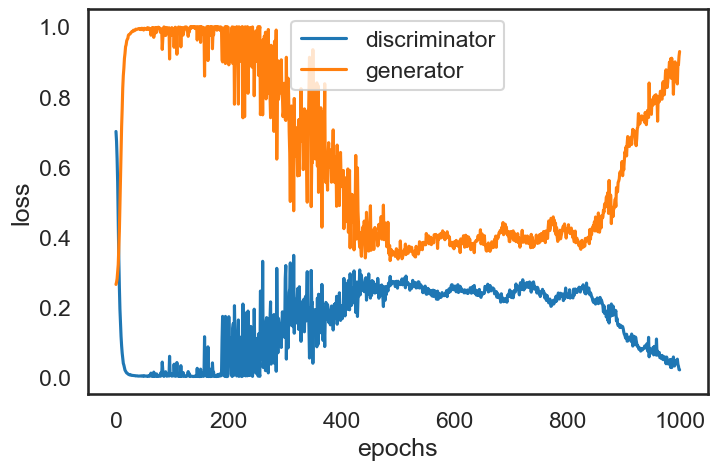

In [38]:
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=loss_df, x='epochs', y='D_loss', label='discriminator')
sns.lineplot(data=loss_df, x='epochs', y='G_loss', label='generator')
ax.set_xlabel('epochs')
ax.set_ylabel('loss');

### generated data from trained generator

In [39]:
input_noise = torch.rand(1, 10000, 44)
input_condition = torch.LongTensor(1, 10000, 1).random_(0, 1)
print(input_noise.shape)
print(input_condition.shape)

torch.Size([1, 10000, 44])
torch.Size([1, 10000, 1])


In [40]:
# sns.lineplot(input_noise[0])

In [41]:
generated_samples = netG(input_noise, input_condition)
generated_data_array = generated_samples.detach().numpy().squeeze()
generated_data_unscaled = scaler.inverse_transform(generated_data_array)
generated_data_df = pd.DataFrame(generated_data_unscaled, columns=column_names)
print(f"generated_data: {generated_data_df.shape}")

generated_data: (10000, 44)


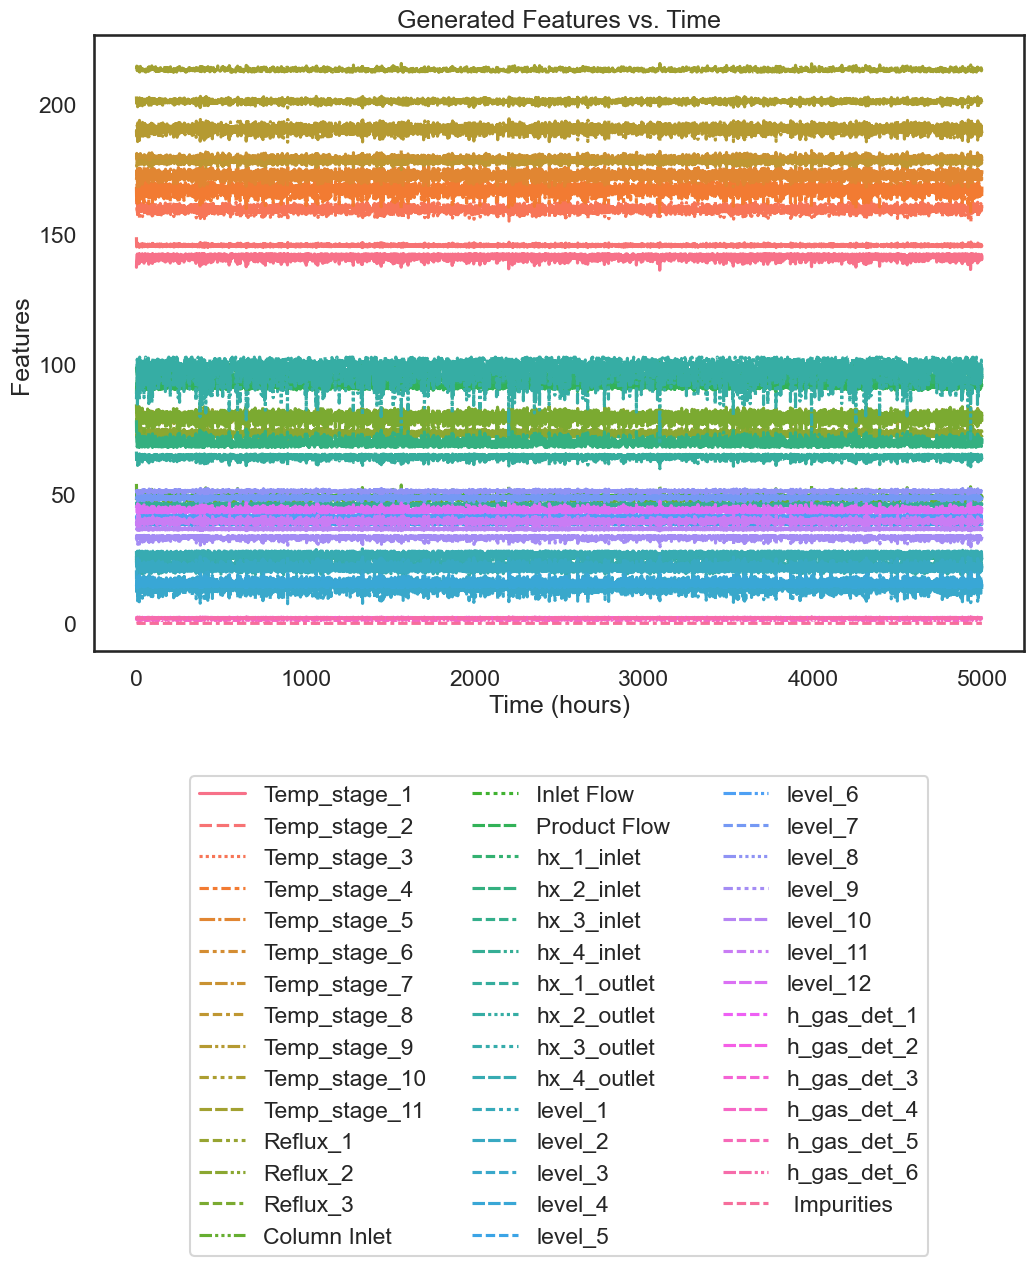

In [42]:
plt.figure(figsize=(12,8))
sns.lineplot(data=generated_data_df[0:5000])
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -1), ncols=3)
plt.title('Generated Features vs. Time')
plt.xlabel('Time (hours)')
plt.ylabel('Features');

### plotting the comparison between each original and generated feature

In [214]:
def plot_comparison(original_df: pd.DataFrame, 
                    generated_df: pd.DataFrame, 
                    n_timepoints: int,
                    column_names: list):
    """plots each feature of the original data compared to the generated data for the first 0 to n_timepoints."""
    for name in column_names:
        fig, ax = plt.subplots()
        sns.lineplot(data=original_df[0:n_timepoints], x=np.arange(0, n_timepoints), y=name, label='original data')
        sns.lineplot(data=generated_df[0:n_timepoints], x=np.arange(0, n_timepoints), y=name, label='generated data')
        ax.legend()
        ax.set_title(f"{name} vs. Time")
        ax.set_xlabel('Time')
        ax.set_ylabel(name);

/var/folders/7m/035mpxc12mg3_wj_0q496wxc0000gn/T/ipykernel_32519/129650624.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


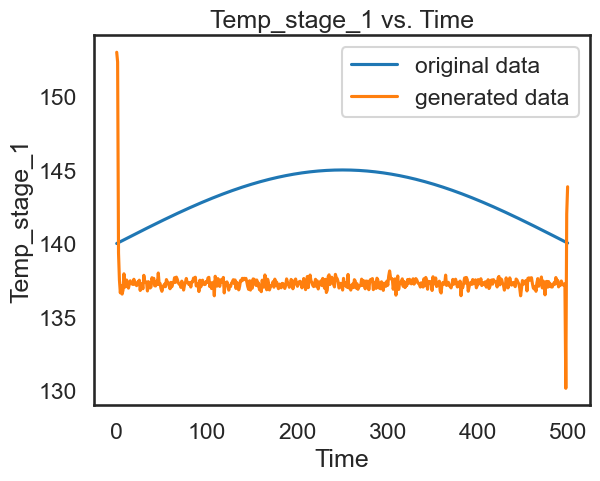

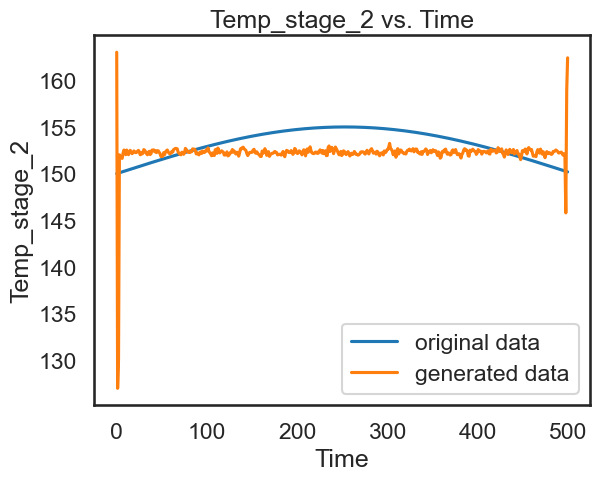

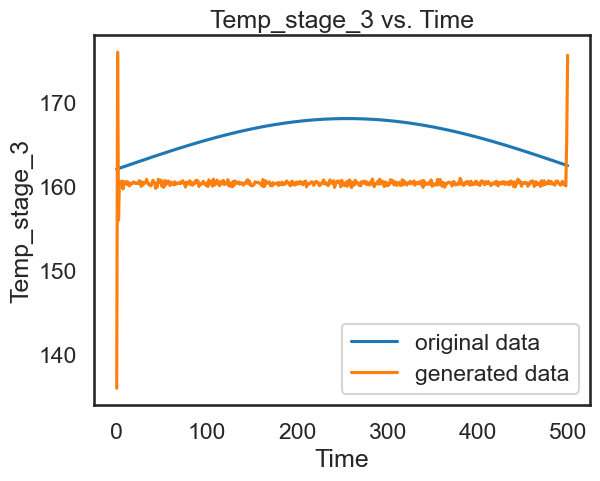

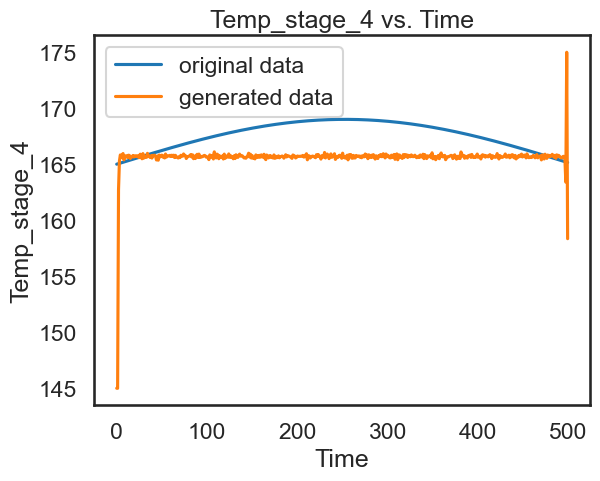

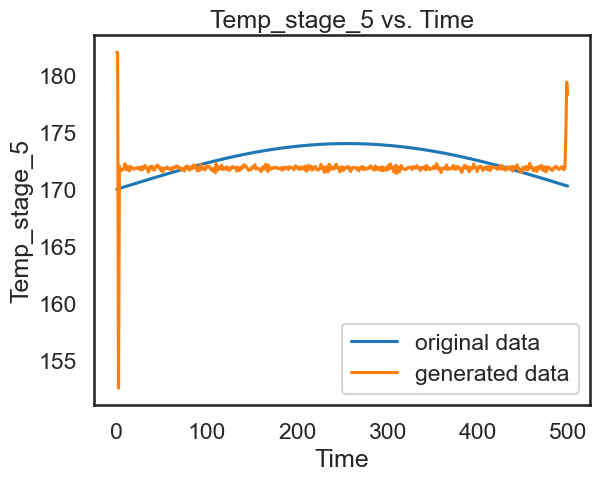

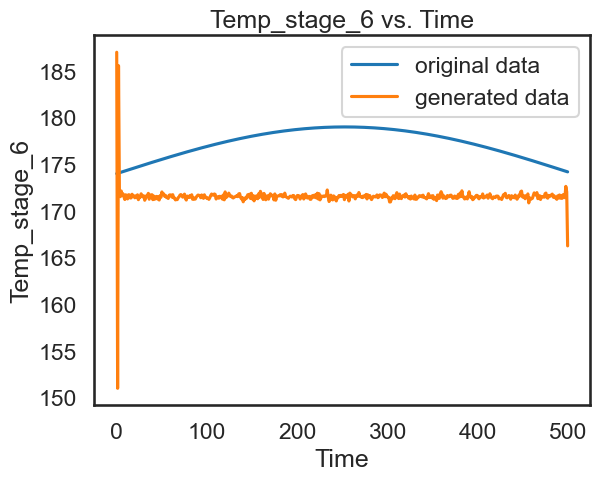

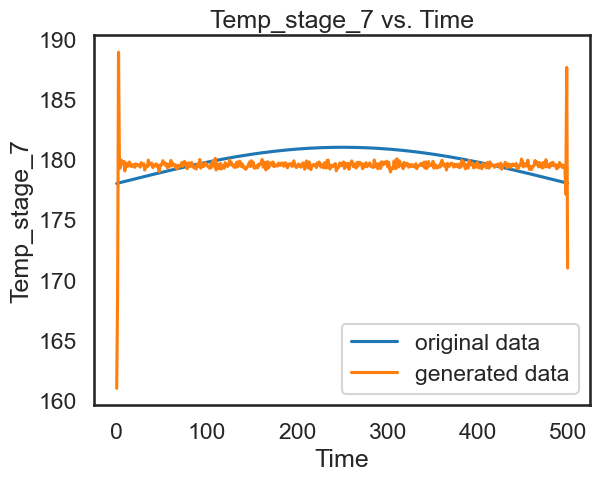

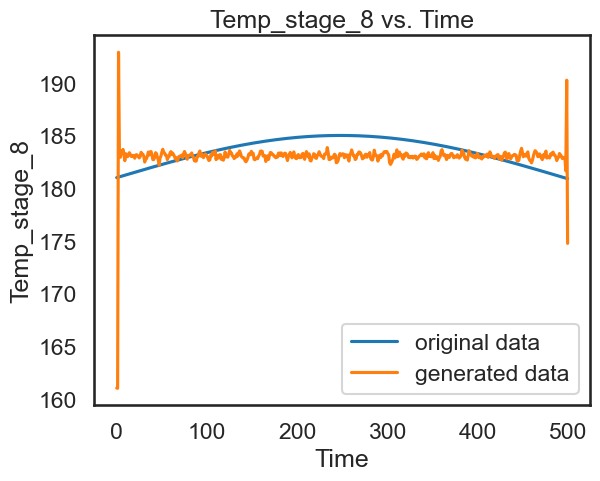

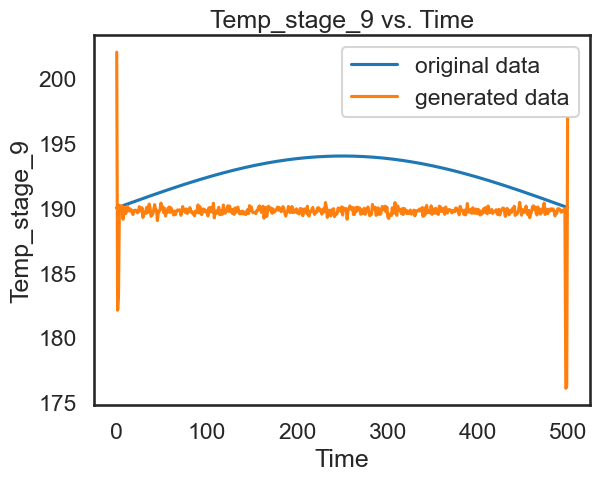

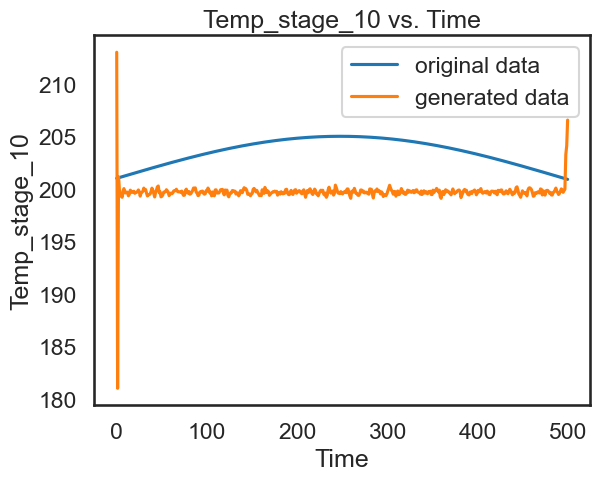

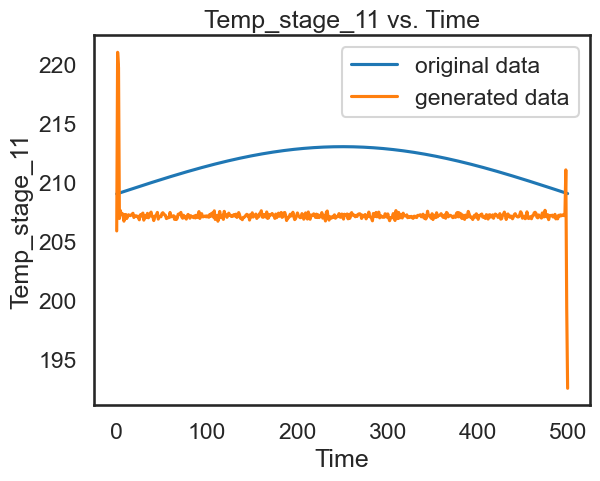

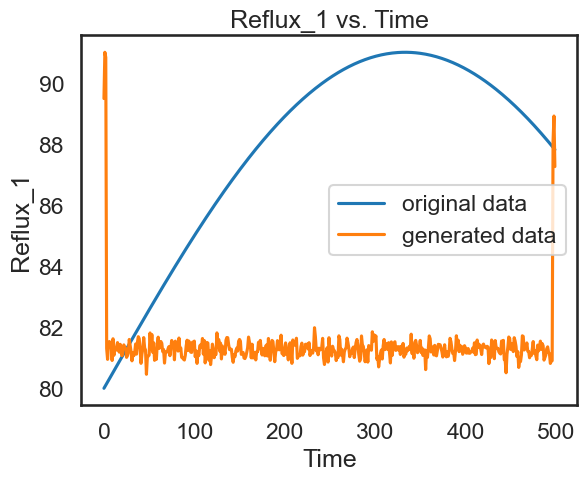

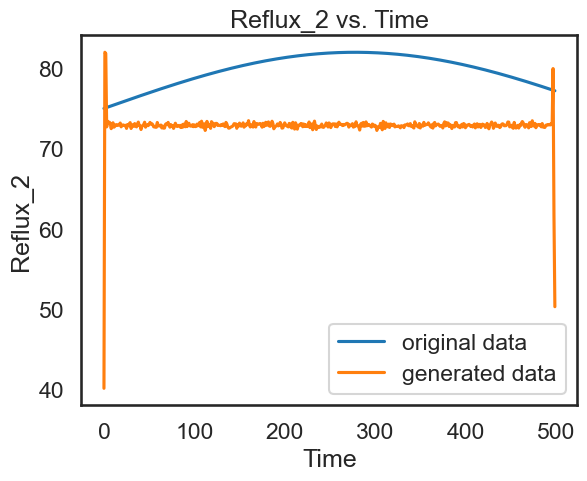

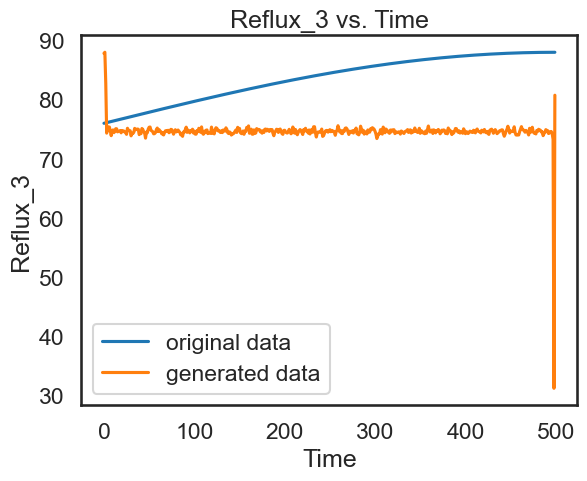

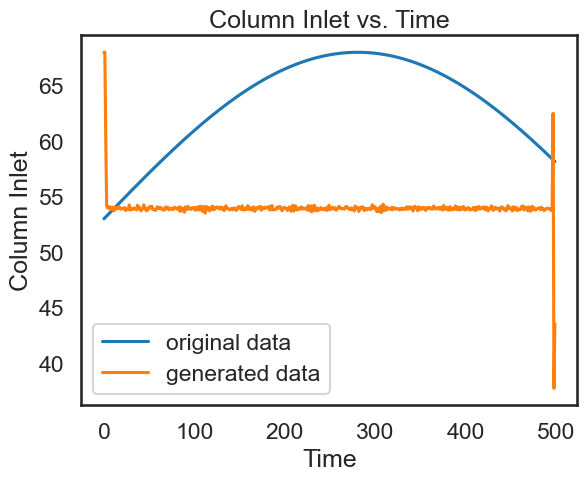

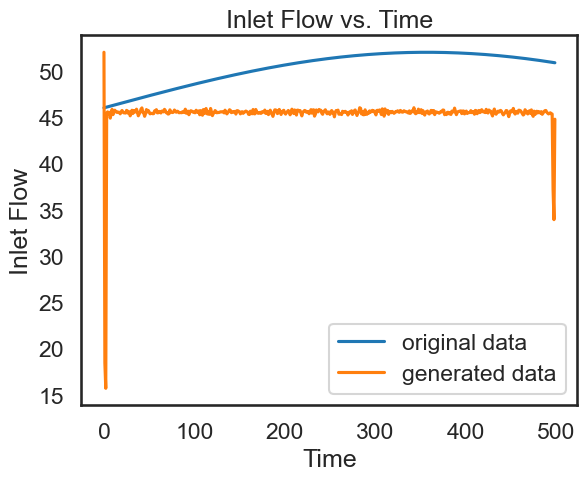

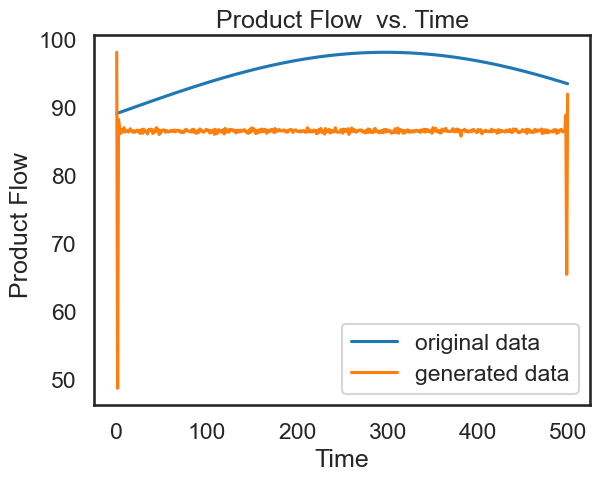

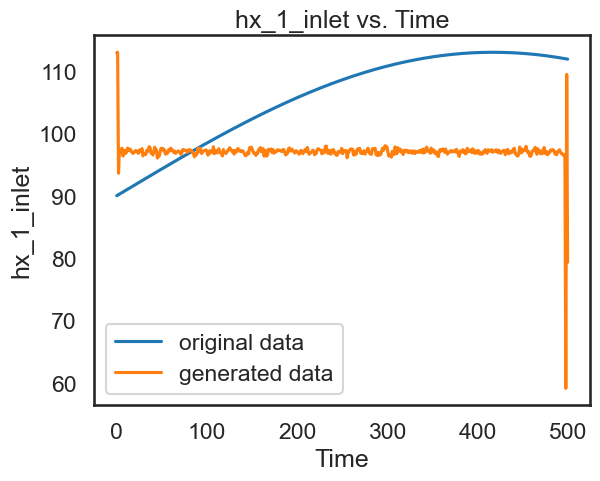

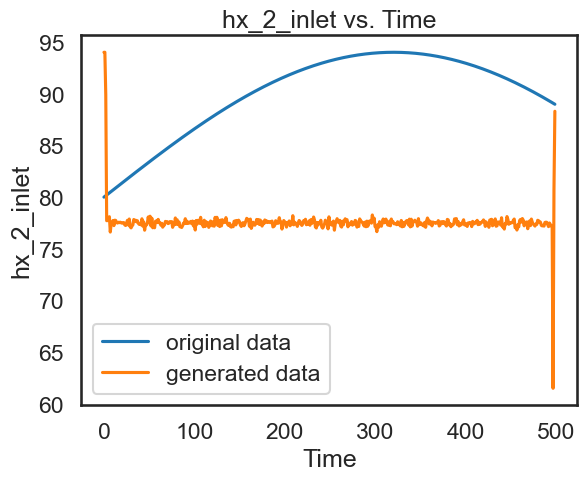

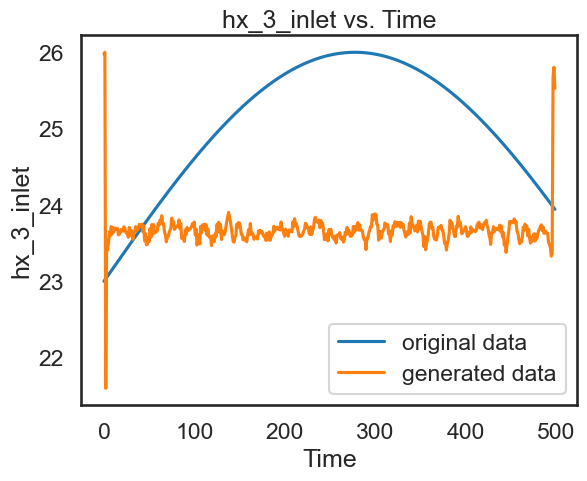

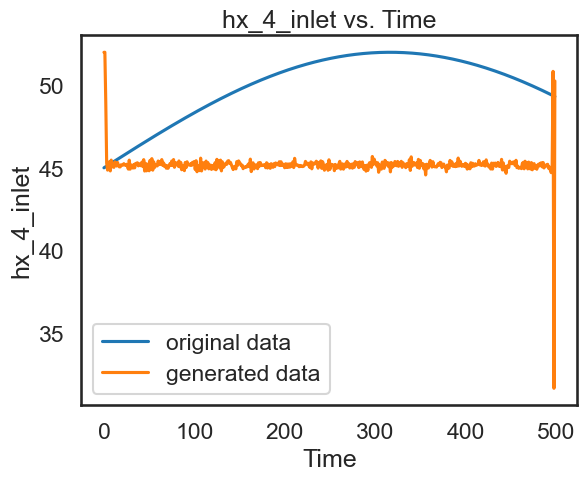

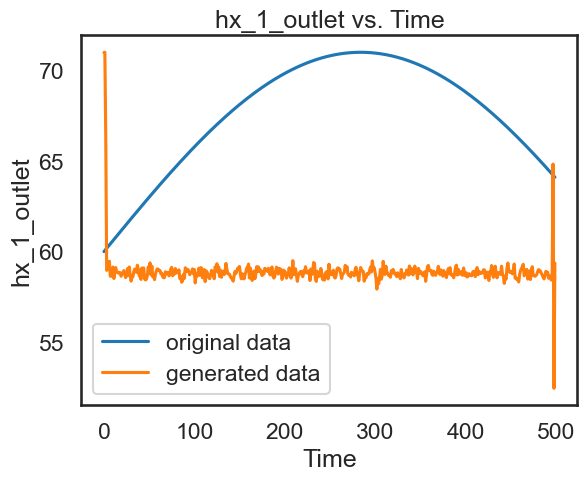

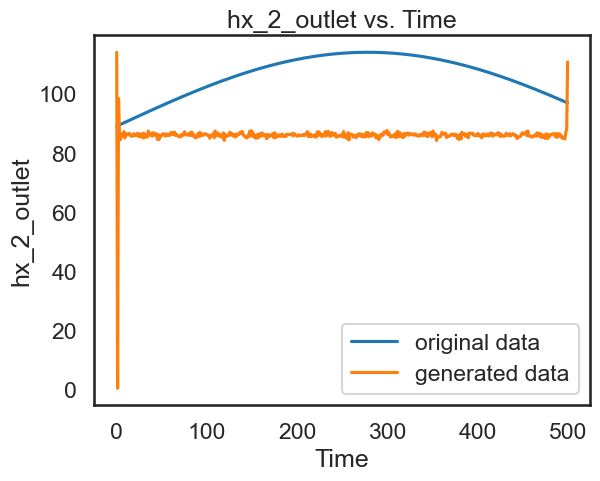

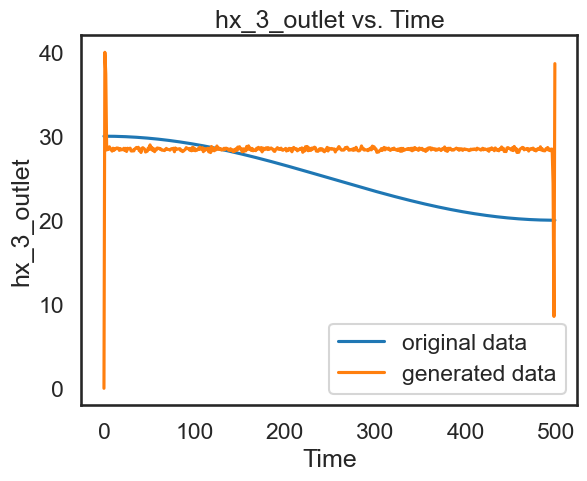

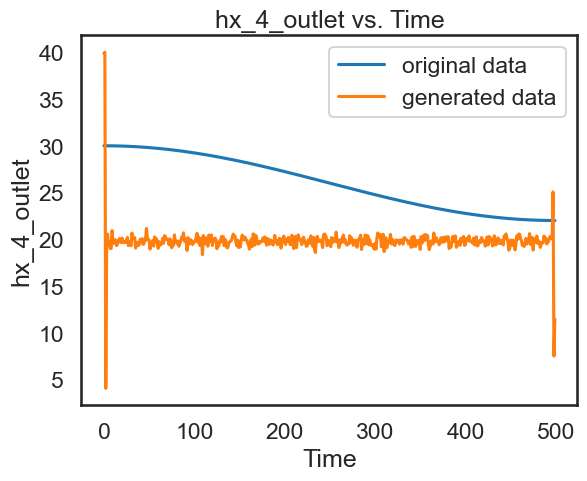

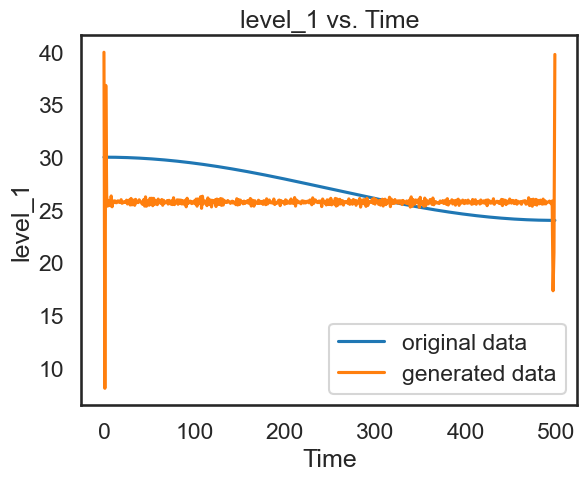

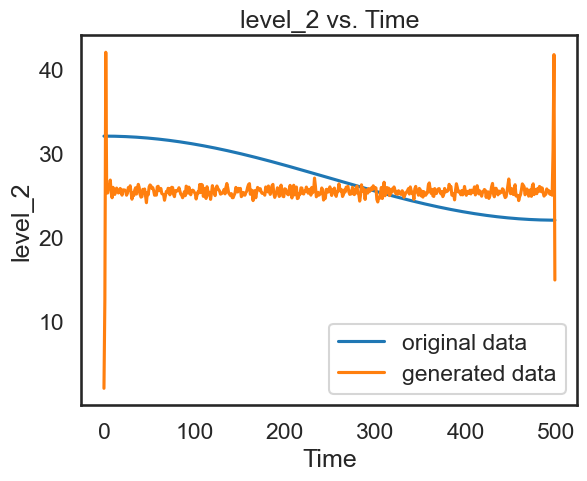

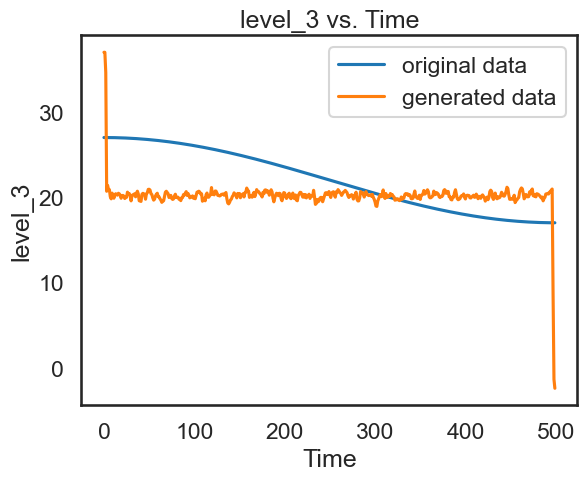

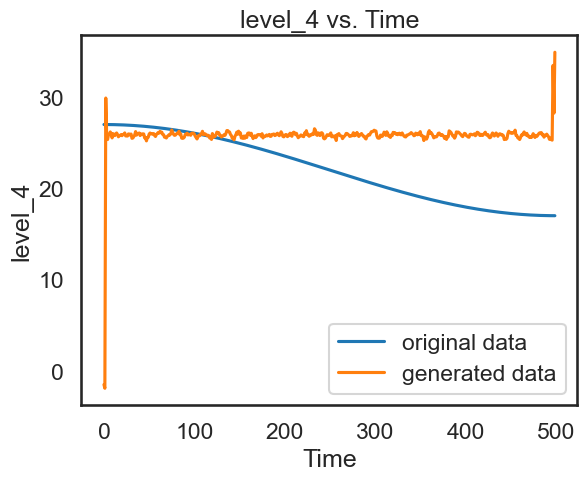

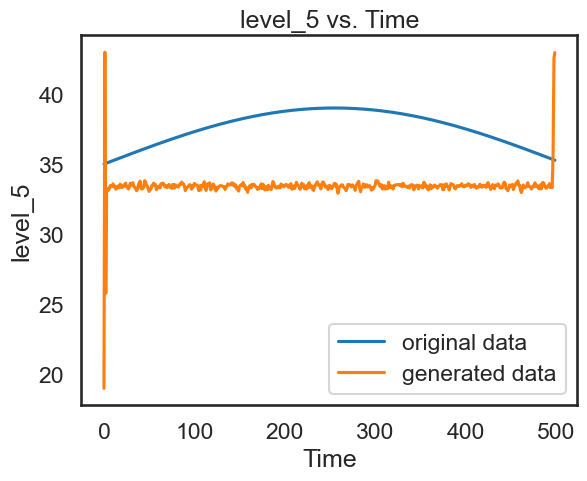

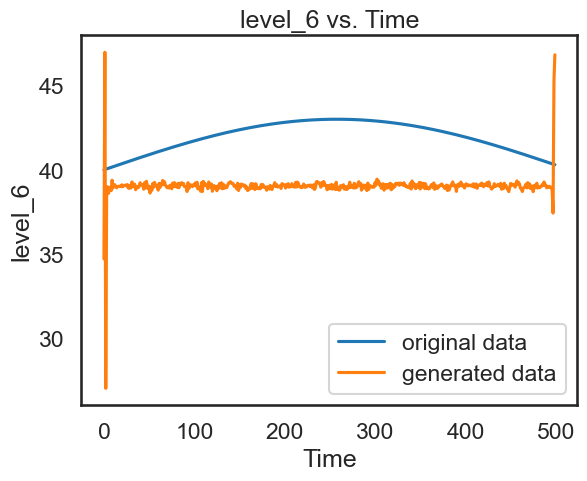

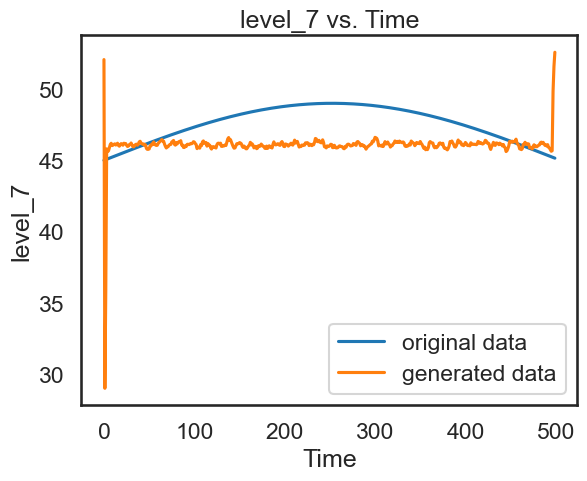

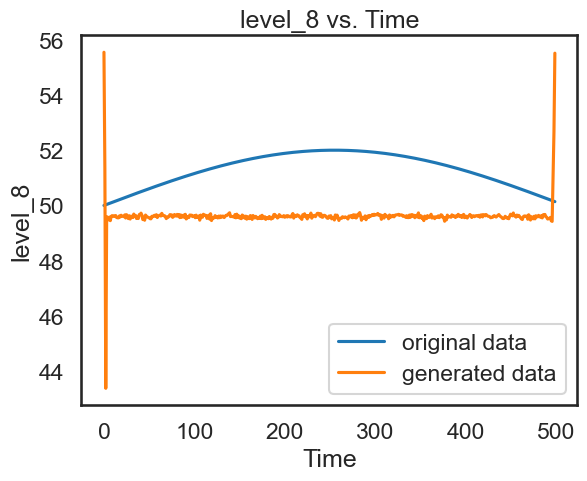

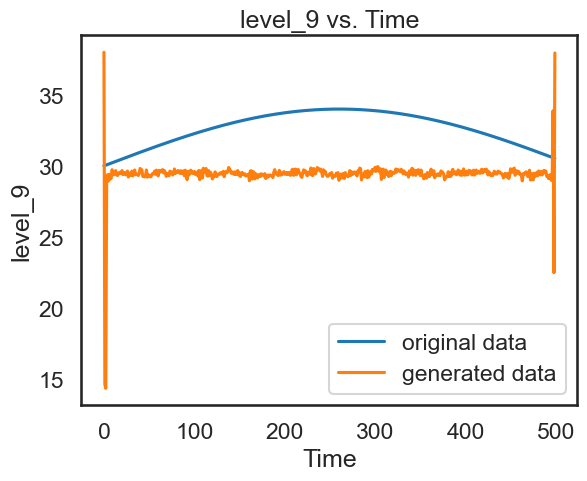

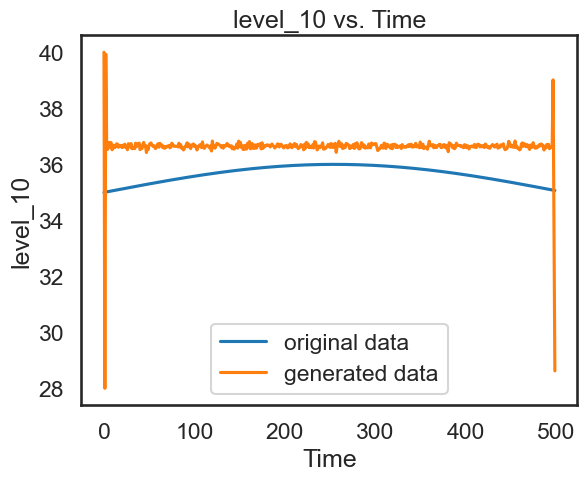

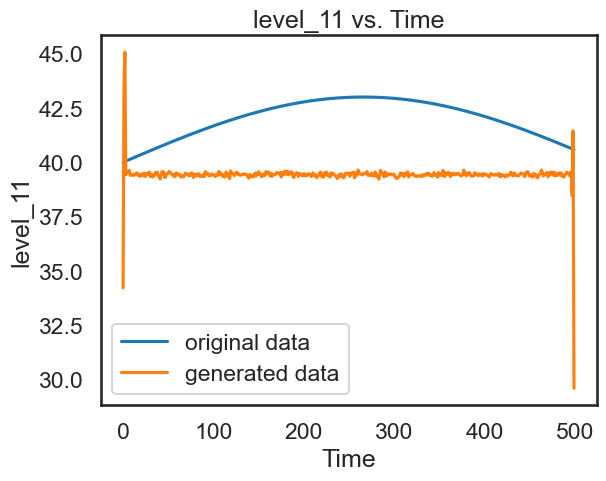

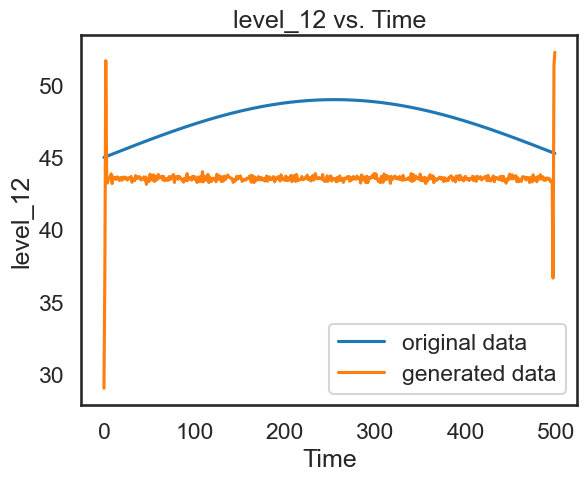

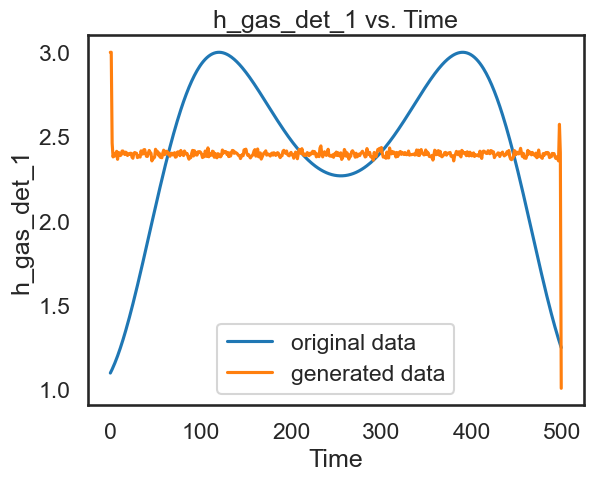

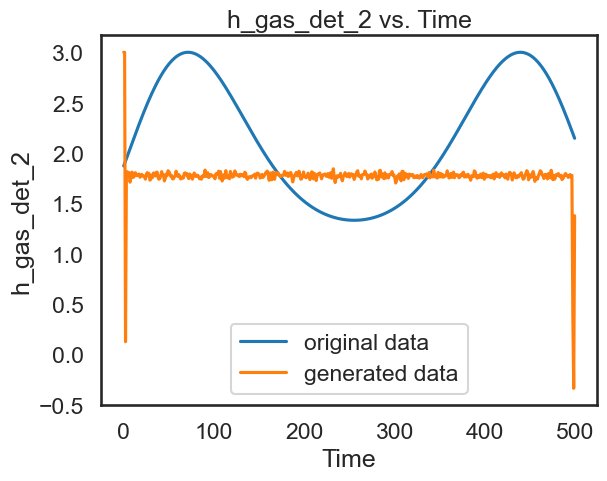

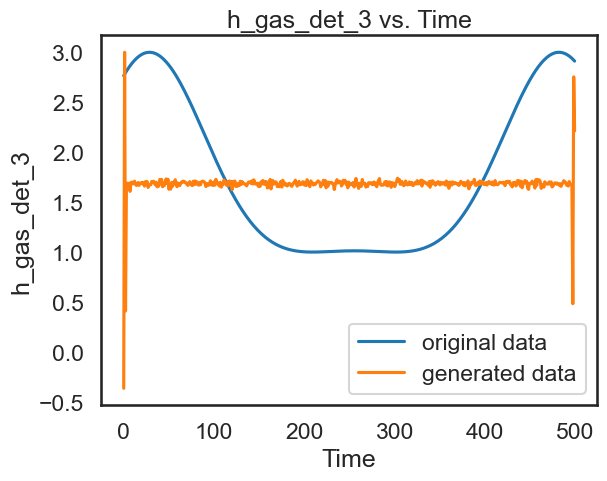

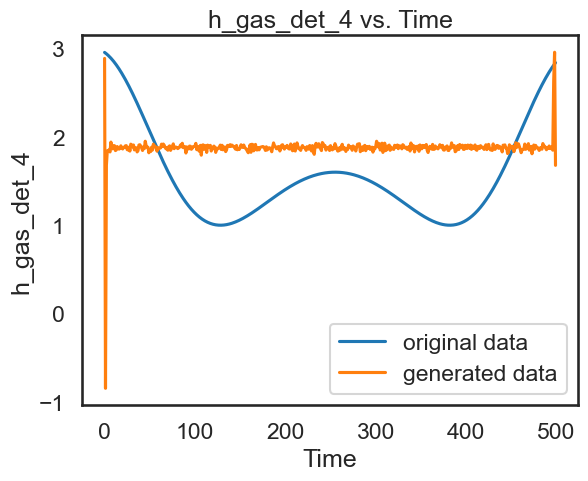

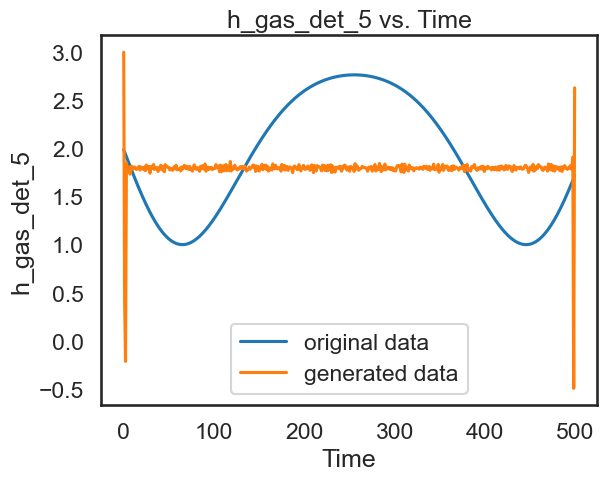

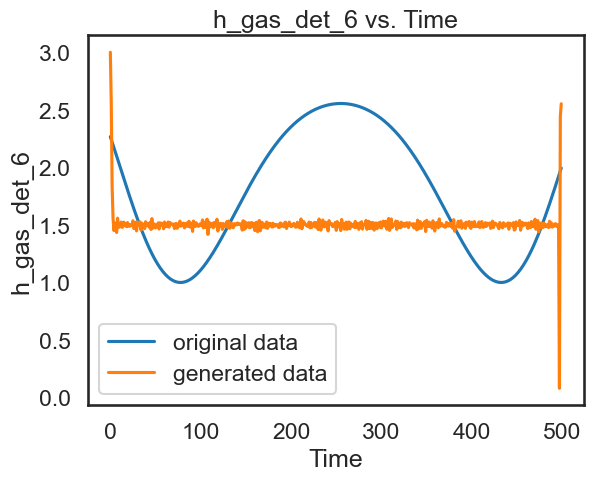

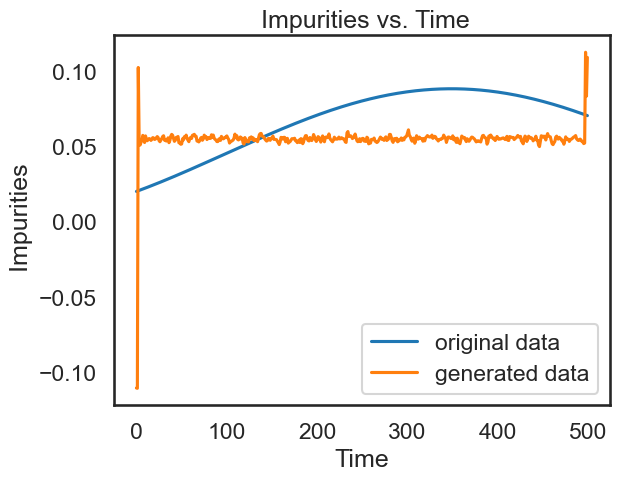

In [215]:
plot_comparison(original_df=df,
                generated_df=generated_data_df,
                n_timepoints=500,
                column_names=column_names)